In [13]:
# IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from data_plotting import Plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [14]:
# CREATE DATASET
np.random.seed(42)
X, y = make_blobs(n_samples=100, centers=2, random_state=42)



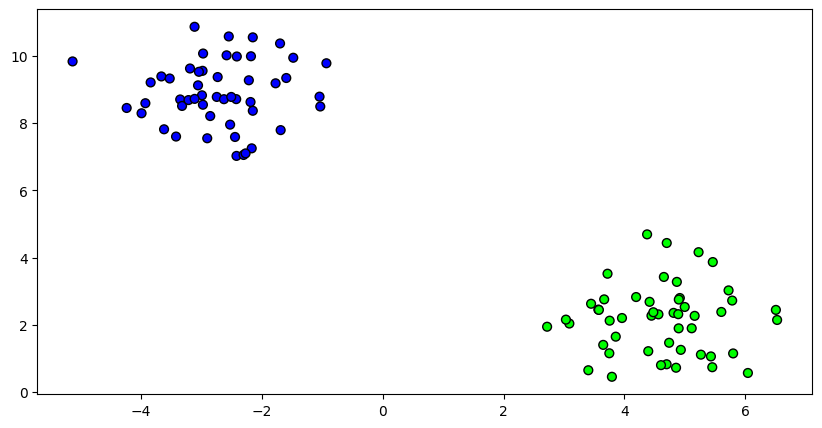

In [15]:
# VISUALIZE DATASET
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="brg", edgecolors="k")
plt.show()


In [16]:
# SCALE DATASET
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [17]:
# TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [18]:
# CREATE ESTIMATOR
from sklearn.base import BaseEstimator
from my_base_models import MySVMBase


class MyLinearHardMargSVC(BaseEstimator, MySVMBase):
    def __init__(self, eta0=1, eta_d=1000, n_epochs=1000):
        """
        This class uses hard margin SVM to classify the data. It strictly enforces 
        that all data points are correctly classified with no margin violations.
        
        :param eta0: Learning rate parameter
        :param eta_d: Learning rate decay parameter 
        :param n_epochs: Number of epochs
        :param random_state: 
        """

        super().__init__()
        self.eta0 = eta0
        self.eta_d = eta_d
        self.n_epochs = n_epochs
        self.Js = []  # Container for losses
        self.intercept_ = None
        self.coef_ = None
        self.support_vectors_ = None

    def fit(self, X, y):
        """
        This function fits the model to the training data. It returns "self" due 
        to the convenient way like:

        CHAINING: 
        "model = SomeModel().fit(X, y).predict(X_test)" 

        OR IN PIPELINE:
        "from sklearn.pipeline import Pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', SomeModel())
        ])
        pipeline.fit(X_train, y_train)"


        :param X: Feature dataset
        :param y: Labels
        :returns: self
        """
        # Random initialization of weights and bias
        coef_ = np.random.randn(X.shape[1], 1)  # number of feature weights
        intercept_ = 0

        X_t, t = self.transform_datapoints_to_positive_and_negative(X, y)

        # Training
        for epoch in range(self.n_epochs):
            X_t_sv, t_sv, _ = self.select_margin_violators(X_t, t, intercept_, coef_)

            # Hard margin loss (for visualization purposes)
            J = 1 / 2 * (coef_ * coef_).sum()
            self.Js.append(J)

            # Compute gradients (No C term since there is no regularization for slack variables)
            w_gradient_vector = coef_ - X_t_sv.sum(axis=0).reshape(-1, 1)
            b_derivative = -t_sv.sum()

            # Update weights and bias
            eta = self.eta(epoch)
            coef_ = coef_ - eta * w_gradient_vector
            intercept_ = intercept_ - eta * b_derivative

        _, _, support_vectors_idx = self.select_margin_violators(X_t, t, intercept_, coef_)
        self.intercept_ = np.array([intercept_])
        self.coef_ = np.array([coef_])
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return self.decision_function(X) >= 0


In [19]:
# TRAIN
eta_0 = 1
eta_d = 100
n_epochs = 1_000
svc1 = MyLinearHardMargSVC(eta0=eta_0, eta_d=eta_d, n_epochs=n_epochs)
svc1.fit(X_train, y_train)

MyLinearHardMargSVC(eta_d=100)

In [20]:
# PREDICT
y_pred = svc1.predict(X_test)


In [21]:
# CROSS VALIDATION
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svc1, X_test, y_test, cv=10, scoring="accuracy")
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [22]:
print(svc1.show_parameters())

coef_:
[[[ 0.9430615 ]
  [-0.53767996]]]

intercept_:
[0.01133423]

support_vectors_:
[[ 0.9117622  -0.23913084]
 [-0.70314458  0.64687595]]


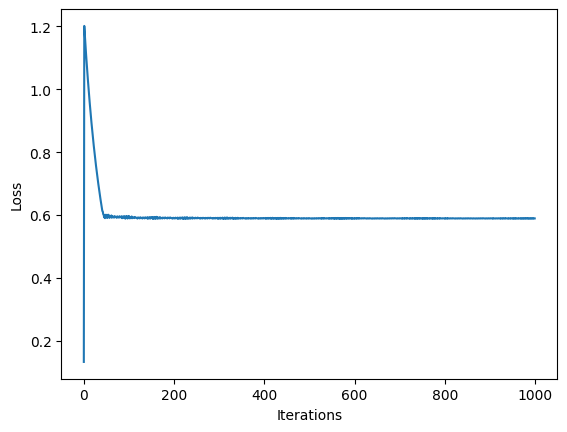

In [23]:
svc1.show_loss_curve()

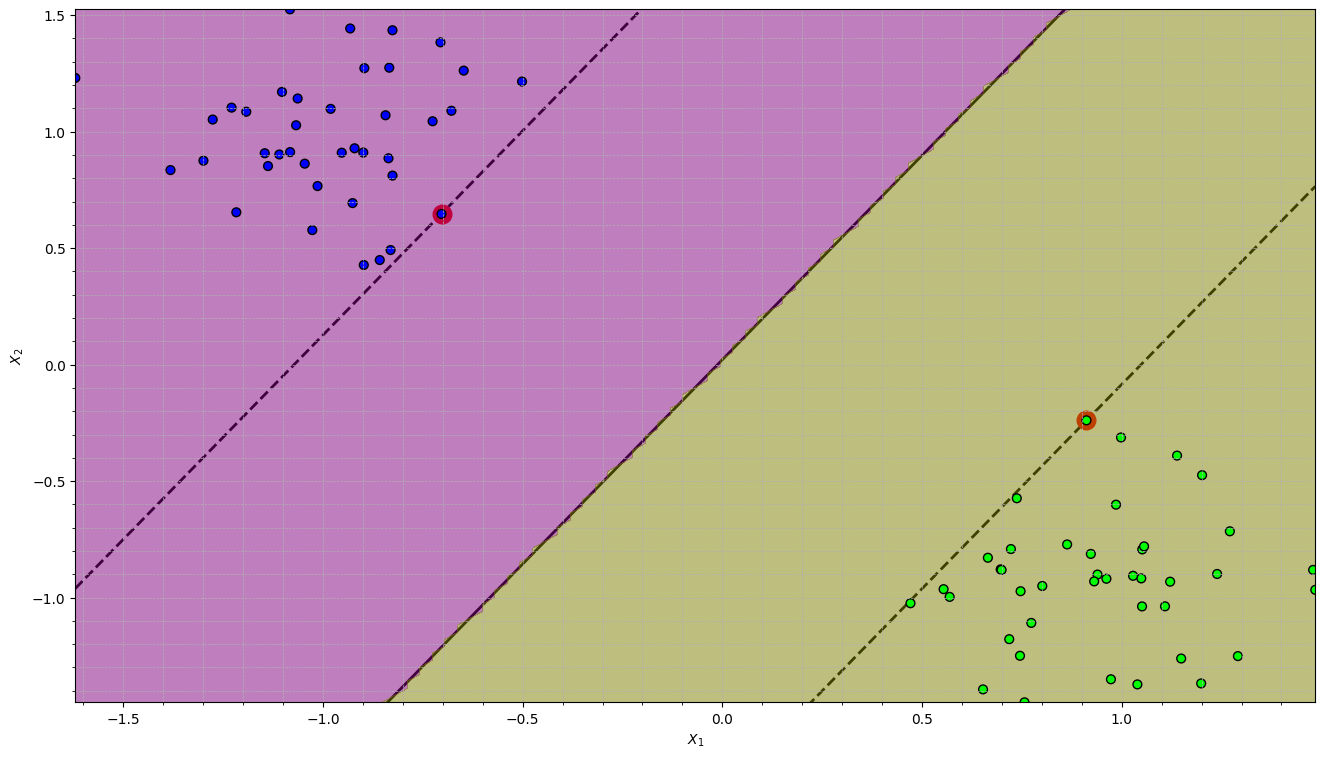

In [24]:
# PLOT
plot = Plots()
plot.plot_decision_boundary(svc1, X_train, y_train, svm_linear=True)